<a href="https://colab.research.google.com/github/simonesilvestri97/American-Tweets-Analysis-NLP/blob/master/4_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMAGE CLASSIFICATION

In this Notebook, you will learn how to:

1. Work with images (rather than Numpy arrays like in the MNIST database)

2. Add a dropout layer

3. Use **callbacks** in Keras (i.e., a set of functions to be applied during the training stage)

4. Fit the model with a batch generator

5. Save model results (i.e., weigths) for future use

6. Perform data augmentation

In [1]:
import os, shutil
from keras import layers
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import load_model
import matplotlib.pyplot as plt

### 1. UPLOADING THE DATABASE


In [ ]:

# The directory where we will
# store our smaller dataset/
base_dir = "/ComputerVision/cats_and_dogs_small"

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')


Let's control how many pictures we have in each training split (train/validation/test):

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


### 2. BUILDING THE NETWORK


**STRUCTURE OF THE CONVNET**

We are re-using a similar structure to the one used to classify MNIST digits. 

However, since we now have bigger images (and a more complex problem) we will build a **deeper** convnet, with

* One more Conv2D + MaxPooling2D stage. 

In this way, we augment the capacity of the network and further reduce the size of the feature maps, so that they aren't overly large when we reach the *Flatten* layer.

In this example, we decide to start with inputs of size 150 x 150.


******************************************************************************************

**The depth of the feature maps will progressively increase in the network (from 32 to 128),    while the size of the feature maps will decrease (from 148x148 to 7x7).  
This is a pattern that you will see in almost all convnets.**

******************************************************************************************

**FINAL LAYER**

We are dealing with a binary classification problem. Hence, our final layer is a single unit (a Dense layer of size 1) and we will use a  sigmoid activation. This unit will encode the probability that the network is looking at one class or the other (i.e., a dog versus a cat).

In [ ]:
#from tensorflow.keras import layers
#from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

**COMPILING THE MODEL**

* We will use the RMSprop optimizer. 
* Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [ ]:
#from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


### 3. DATA PREPROCESSING

These are the steps necessary to turn the JPEG files that we have into floating point tensors

1. Read the picture files.

2. Decode the JPEG content to RBG grids of pixels

3. Convert these into floating point tensors

4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (neural networks prefer to deal with small input values).

Keras has a module with image-processing helper tools, located at `keras.preprocessing.image`, which contains the **class** `ImageDataGenerator` that automatically turns images files on disk into batches of preprocessed tensors


In [ ]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale all images by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
# Resize all images to 150 X 150 (This is the parameter that we passed to our convnet)
train_generator = train_datagen.flow_from_directory(
        
        train_dir, # target directory
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary') # Since we use binary_crossentropy loss, we need binary labels

Found 2000 images belonging to 2 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
        validation_dir, # validation directory
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.



We can have a look at the output of one of these generators. 

Each generator yields batches of 150x150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 20 is the number of samples in each batch (the `batch size`). 

The generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to break the iteration loop at some point.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


****************************************************
### CALLBACKS

In Keras, `callbacks` is a set of functions to be applied at given stages of the training procedure.

We are going to use two callbacks functions:

1. **EarlyStopping**, which stops the training when a monitored quantity has stopped improving. It takes the following arguments:

    * `monitor`: The quantity to be monitered. In our case, we are going to monitor `val_acc`, the accuracy computed on the validation set (data that the model has never seen before). Alternatively, you could also monitor `val_loss`, the value of cost function for our cross-validation data.
    * `min_delta`: minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
    * `patience`: number of epochs that produced the monitored quantity with no improvement after which training will be stopped.
    * `verbose`: verbosity mode 
    * `mode`: one of auto, min, max. In *min* mode, training will stop when the quantity monitored has stopped decreasing; in *max* mode it will stop when the quantity monitored has stopped increasing; in *auto* mode, the direction is automatically inferred from the name of the monitored quantity


2. **CSVLogger**, which saves the results of each epoch to a csv file. This is fundamental to later recover the training data with no need to retrain the model.  

The full list of callbacks can be found at: https://keras.io/callbacks/

In [ ]:
earlystop = EarlyStopping(
    monitor='val_acc',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

In [ ]:
csv_logger = CSVLogger('training.log', 
                       separator=',', 
                       append=False)

### 4. FITTING THE MODEL WITH A BATCH GENERATOR

At this point, we can fit our model to the data using the generator with the `fit()` method.

The method expects:

* **A Python generator** that yields batches of inputs and targets indefinitely, like our `train_generator` does. 


* `steps_per_epoch` argument: Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.


* Number of `epochs` argument


* A `validation_data` argument. This argument is allowed to be a data generator itself (like our `validation_generator`, but it could be a tuple of Numpy arrays as well. 


* If you pass a `generator` as validation_data, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation. Since we have 1000 images in our validation sample, and our batches are 20-sample large, we need (1000/20)=50 `validation_steps`.

* `callbacks`:  We can pass a list of callbacks that we previously defined.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      #callbacks=[earlystop, csv_logger]
)


Epoch 1/30
100/100 [==============================] - 63s 626ms/step - loss: 0.6925 - acc: 0.5305 - val_loss: 0.6836 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 67s 672ms/step - loss: 0.6588 - acc: 0.6005 - val_loss: 0.6641 - val_acc: 0.5930
Epoch 3/30
100/100 [==============================] - 67s 673ms/step - loss: 0.6288 - acc: 0.6565 - val_loss: 0.6544 - val_acc: 0.6100
Epoch 4/30
100/100 [==============================] - 66s 659ms/step - loss: 0.5797 - acc: 0.6950 - val_loss: 0.6317 - val_acc: 0.6310
Epoch 5/30
100/100 [==============================] - 66s 659ms/step - loss: 0.5414 - acc: 0.7300 - val_loss: 0.6252 - val_acc: 0.6640
Epoch 6/30
100/100 [==============================] - 66s 662ms/step - loss: 0.5183 - acc: 0.7440 - val_loss: 0.5696 - val_acc: 0.7090
Epoch 7/30
100/100 [==============================] - 73s 733ms/step - loss: 0.4788 - acc: 0.7595 - val_loss: 0.5727 - val_acc: 0.6950
Epoch 8/30
100/100 [==============================] - 7


#### SAVE THE MODEL


In [ ]:
model.save('cats_and_dogs_small_1.h5')


#### PLOT ACCURACY AND LOSS OF THE MODEL

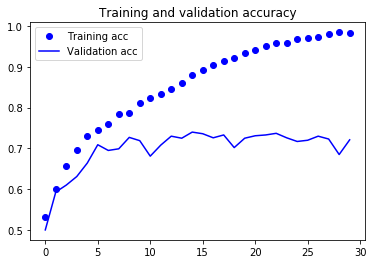

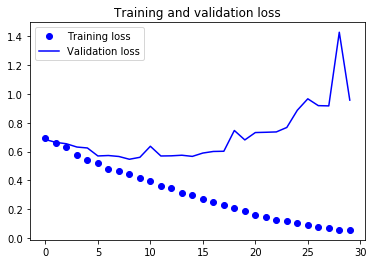

In [ ]:
#IF YOU ARE PATIENT ENOUGH TO WAIT FOR THE MODEL TO TRAIN


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#IF YOU UPLOAD EXISTING MODEL
import pandas as pd
log_data = pd.read_csv('/Computer Vision/training.log', sep=',', engine='python')

log_data.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.5245,0.693672,0.619,0.673570
1,1,0.6160,0.657722,0.608,0.653364
2,2,0.6665,0.611479,0.658,0.615787
3,3,0.7045,0.570958,0.667,0.600365
4,4,0.7360,0.533764,0.668,0.626678


In [ ]:
acc = log_data['acc']
val_acc = log_data['val_acc']
loss = log_data['loss']
val_loss = log_data['val_loss']

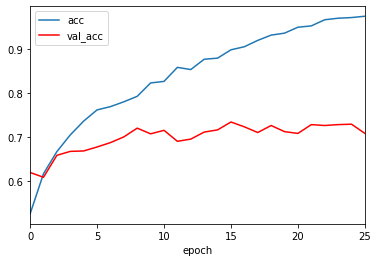

In [ ]:
# very poor but fast way to plot stuff...
ax = plt.gca()

log_data.plot(kind='line',x='epoch',y='acc',ax=ax)
log_data.plot(kind='line',x='epoch',y='val_acc', color='red', ax=ax)

plt.show()

These curves indicate *overfitting*. The training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-72%. 

The training loss reaches its minimum after only five epochs then stalls, while the validation loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is a serious concern. 

You should know how to reduce overfitting with dropout and weight decay (L2 regularization). Let's now learn a technique, specific to computer vision and deep learning models: **data augmentation**.


### 5. DATA AUGMENTATION

Since we have overfitting problems, we need to augment our data. We can do this in Kears by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. For instance:


In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Here, we are performing the following operations:

* `rotation_range` randomly rotates images. It is a value in degrees (0-180) that indicates the range within which to randomly rotate pictures.

* `width_shift_range` and `height_shift_range` indicates the ranges within which to randomly translate pictures vertically or horizontally. They are ranges (as a fraction of total width or height)

* `shear_range` randomly applies shearing transformations.

* `zoom_range` randomly zooms inside pictures.

* `horizontal_flip` randomly flips half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).

* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

These are just some of the options available. For more options, see the Keras documentation
Let's take a look at our augmented images:

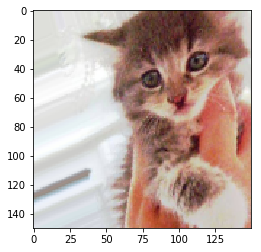

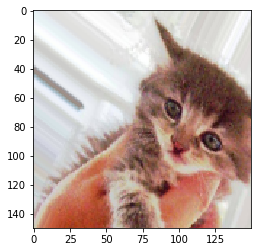

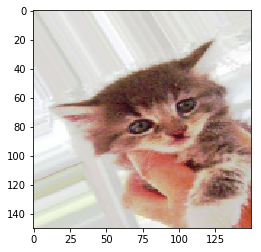

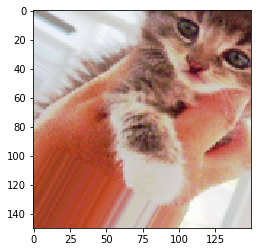

In [ ]:
# This is module with image preprocessing utilities

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We select one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

By using this data augmentation configuration, our network will not see the same image twice. 

However, the input images that the network sees are highly correlated since they have the same original image in common. Thus, we will reduce overfit but just to a certain extent. 

To further reduce overfit, we now add a `Dropout` layer to our model, right before the densely-connected classifier:

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


Let's train our network using data augmentation and dropout. We start without `EarlyStopping` callback. 

In [ ]:
#NO EARLYSTOPPING CALLBACK
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')


csv_logger = CSVLogger('training_augmented.log',
                       separator=',', 
                       append=False)


history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[csv_logger])

In [ ]:
model.save('cats_and_dogs_small_2.h5')

Let's see if our results improved

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

After using data augmentation and dropout, we have avoided overfitting: the training curves are rather closely tracking the validation curves. We now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

We could slightly improve our accuracy by fine-tuning the network's parameters (e.g., number of layers or number of filter in the convolution layers). However, given the little data we have, it would be higher to reach a higher accuracy. 

This is why we are then going to learn how to take advantage of pre-trained models. 

**************************************************************************************************************

**MODEL FITTING WITH EarlyStopping CALLBACK**

Let's see whether our results would change by using the `EarlyStopping` callback. We expect no change in the results but also we expect to run fewer epochs. Indeed, the model fit stops after 68 epochs.


In [ ]:
#WITH EARLYSTOPPING CALLBACK

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

earlystop = EarlyStopping(
    monitor='val_acc',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

csv_logger = CSVLogger('training_augmented_earlystopping.log',
                       separator=',', 
                       append=False)


history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[earlystop, csv_logger])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 93s 929ms/step - loss: 0.6921 - acc: 0.5303 - val_loss: 0.6760 - val_acc: 0.5774
Epoch 2/100
100/100 [==============================] - 96s 957ms/step - loss: 0.6806 - acc: 0.5609 - val_loss: 0.6669 - val_acc: 0.5685
Epoch 3/100
100/100 [==============================] - 91s 908ms/step - loss: 0.6597 - acc: 0.5846 - val_loss: 0.6524 - val_acc: 0.5926
Epoch 4/100
100/100 [==============================] - 92s 916ms/step - loss: 0.6465 - acc: 0.6071 - val_loss: 0.6158 - val_acc: 0.6637
Epoch 5/100
100/100 [==============================] - 90s 903ms/step - loss: 0.6270 - acc: 0.6439 - val_loss: 0.6316 - val_acc: 0.6256
Epoch 6/100
100/100 [==============================] - 90s 898ms/step - loss: 0.6139 - acc: 0.6547 - val_loss: 0.6238 - val_acc: 0.6434
Epoch 7/100
100/100 [==============================] - 90s 897ms/step - loss: 0.5954 - acc: 0.6800 -

In [ ]:
model.save('cats_and_dogs_small_2_earlystopping.h5')

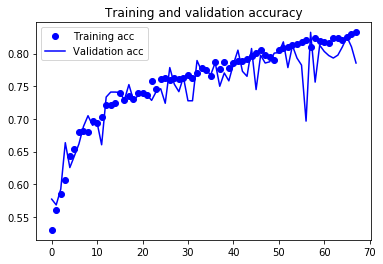

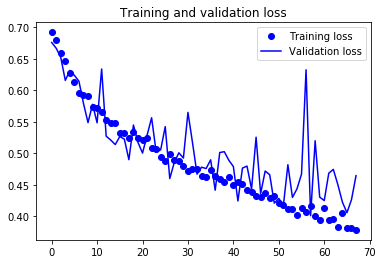

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()